In [47]:
%autoreload 2
%matplotlib inline 

This is for mass outputting smoothed KDE DM maps.

* get DM particles
* do different projections


In [49]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)

In [50]:
from sklearn.neighbors.kde import KernelDensity

In [51]:
import matplotlib.pyplot as plt

In [52]:
from __future__ import (division, print_function)

import cPickle
from scipy.stats import gaussian_kde as kde 

import h5py
import sys
sys.path.append("../")
import get_KDE as getKDE
import extract_catalog as ec
import get_DM_centroids as getDM

In [53]:
from scipy import ndimage

In [54]:
data_path = "../../data/"

## 1. extract data 

In [55]:


# Import file
data_path = "../../data/"
DM_h5file = data_path + \
    "Illustris-1_00135_APillepich_KarenNG_ParticleData_Group_PartType1.h5"

DM_f = h5py.File(DM_h5file)

# Decide how many clusters to import
clstNo = [30]

coord_dict = ec.get_DM_particles(clstNo, DM_f, dataPath="../../data/")


In [56]:
clstNo = [10]

In [57]:
bandwidth = 30 * 4.45 

In [58]:
coord_dict = ec.get_DM_particles(clstNo, DM_f, 
                                 dataPath="../../data/")
clst = coord_dict[clstNo[0]]

In [59]:
fhat_stars = cPickle.load(open("../../data/fhat_I_lum.pkl", "r"))

In [60]:
fhat = \
    getDM.make_histogram_with_some_resolution(
        coord_dict[clstNo[0]], resolution=bandwidth / 2.)

## smooth the data by a lot ...

In [74]:
fhat["log_est"] = np.log(fhat["estimate"])
# I have no freaking clue what sigma refers to.
# It doesn't say in the documentation.
# Perhaps it is how much the signal varies within a region.
smoothed_z = \
    ndimage.gaussian_filter(fhat["estimate"], sigma=1
                           ).transpose()

In [62]:
fhat.keys()

['peaks_colIx',
 'max_peak_dens',
 'log_est',
 'peaks_rowIx',
 'peaks_ycoords',
 'peaks_dens',
 'estimate',
 'eval_points',
 'peaks_xcoords']

In [63]:
fhat["smoothed_est"] = smoothed_z.transpose()

In [64]:
getKDE.find_peaks_from_py_diff(fhat, estKey="smoothed_est",)

## what the histogram looks like

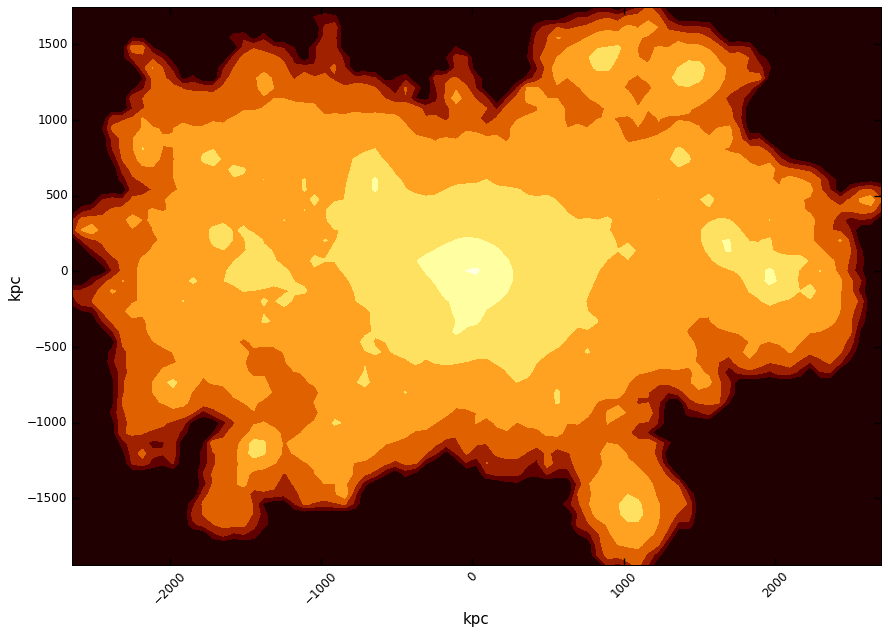

In [65]:
fhat["log_est"] = np.log10(fhat["estimate"] + 1.)
plt.figure(figsize=(15, 10))
plt.subplot('111', axisbg='black', aspect='equal',)

plt.xticks(rotation=45)
plt.contourf(fhat["eval_points"][0], fhat["eval_points"][1],
             fhat["log_est"].transpose(), cmap=plt.cm.afmhot)
plt.xlabel('kpc')
plt.ylabel('kpc')


## what the over smoothed plot looks like

In [66]:
fhat_star = fhat_stars[clstNo[0]]

In [67]:
unit_conversion = 1. / .704
offset = np.sqrt((fhat["peaks_xcoords"][0] - 
                  fhat_star["peaks_xcoords"][0] * unit_conversion) ** 2. + 
                 (fhat["peaks_ycoords"][0] - 
                  fhat_star["peaks_ycoords"][0] * unit_conversion) ** 2.)

In [68]:
_ = map(lambda x: print(len(x)), fhat["eval_points"])

81
56


In [69]:
smoothed_z.shape

(56, 81)

In [76]:
np.min(smoothed_z)

0.0

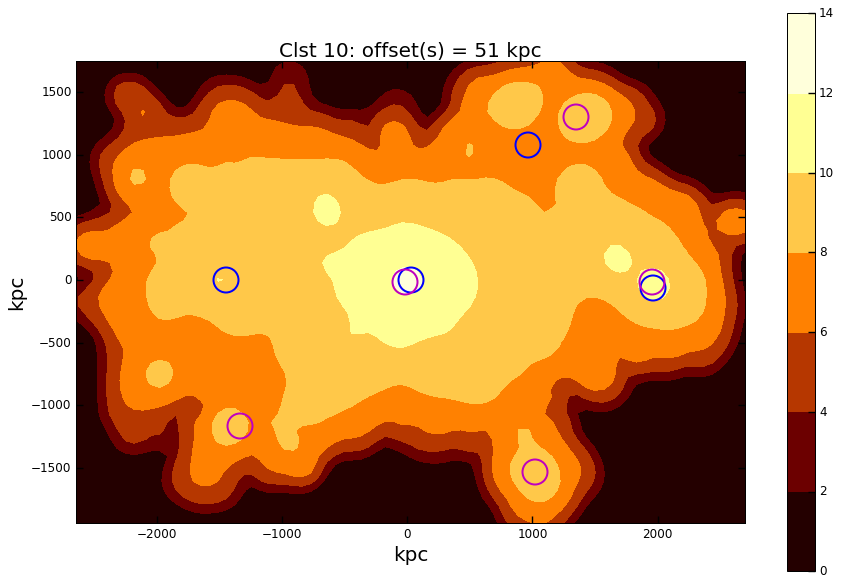

In [77]:
fontsize=20

plt.subplot('111', axisbg='black', aspect='equal',)

plt.contourf(fhat["eval_points"][0], fhat["eval_points"][1],
             np.log(smoothed_z + 1), cmap=plt.cm.afmhot)

plt.plot(fhat["peaks_xcoords"], fhat["peaks_ycoords"], 'bo',
         fillstyle='none', ms=25, mew=2)
plt.plot(fhat_star["peaks_xcoords"] * unit_conversion, 
         fhat_star["peaks_ycoords"] * unit_conversion, 'mo',
         fillstyle='none', ms=25, mew=2)

plt.title(
    "Clst {0}: offset(s) = {1:.0f} kpc".format(clstNo[0], offset))
plt.xlabel('kpc', size=fontsize)
plt.ylabel('kpc', size=fontsize)
plt.colorbar()

In [340]:
def stratify_2D_data(data, layer=5e2):
    assert type(data) is np.ndarray, \
        "`data` is of the Wrong type, needs `np.ndarray`"
    assert np.ndim(data) == 2, \
        "`data` has the wrong dimension."
    layer = int(layer)
    
    # round data to integers 
    data = np.array(map(lambda row: map(int, row), data)
         ).reshape(*data.shape)
    
    return data // layer

In [341]:
fhat_peaks = peak_local_max(fhat["estimate"])

In [342]:
fhat_star_peaks = peak_local_max(fhat_star["estimate"])

In [343]:
star_peaks_x = \
    fhat_star["eval_points"][0][fhat_star_peaks.transpose()[0]]
star_peaks_y = \
    fhat_star["eval_points"][1][fhat_star_peaks.transpose()[1]]
    
DM_peaks_x = \
    fhat["eval_points"][0][fhat_peaks.transpose()[0]]
DM_peaks_y = \
    fhat["eval_points"][1][fhat_peaks.transpose()[1]]

```Python
fontsize=20

plt.subplot('111', axisbg='black', aspect='equal',)

plt.contourf(fhat["eval_points"][0], fhat["eval_points"][1],
             smoothed_z, cmap=plt.cm.afmhot)

plt.plot(DM_peaks_x, DM_peaks_y, 'bo',
         fillstyle='none', ms=25, mew=2)

plt.plot(star_peaks_x * unit_conversion, 
         star_peaks_y * unit_conversion, 'mo',
         fillstyle='none', ms=25, mew=2)

plt.title(
    "Clst {0}: offset(s) = {1:.0f} kpc".format(clstNo[0], offset))
plt.xlabel('kpc', size=fontsize)
plt.ylabel('kpc', size=fontsize)
```

## image segmentation

In [345]:
from skimage.morphology import watershed 
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

In [346]:
image = fhat["smoothed_est"] > 0.40 * np.max(fhat["smoothed_est"])

In [347]:
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, 
                            footprint=np.ones((3, 3)),
                            labels=image)
labels = watershed(image, markers=image)

In [348]:
labels, num_of_objects = ndi.label(image)

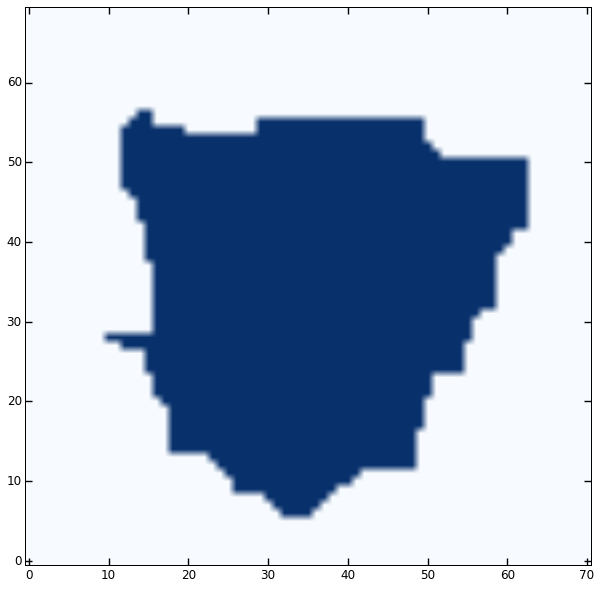

In [349]:
plt.imshow(labels.transpose(), origin='lower')

## 2. downsample to 1% of data points
```Python
size = len(coords)
sample_ix = \
    np.random.choice(range(0, size), 1e-2 * size, 
                     replace=False)
```

## 3. do KDE on downsampled data points 

30 arcsecs * 4.45 kpc / arcsec 

code that Will does not like

```Python
getKDE.find_peaks_from_py_diff(fhat, estKey="smoothed_est",)


max_coords = np.max(coords, axis=0)
max_coords = np.array([int(c) for c in max_coords])

min_coords = np.min(coords, axis=0)
min_coords = np.array([int(c) for c in min_coords])
slice_dim = [0, 1]
grid_width = 2
x_grid, y_grid = \
    np.meshgrid(np.arange(min_coords[slice_dim[0]], 
                          max_coords[slice_dim[0]], grid_width), 
                np.arange(min_coords[slice_dim[1]], 
                          max_coords[slice_dim[1]], grid_width))
grid_coords = np.array([list(coord) 
                        for coord in 
                        zip(x_grid.ravel(), 
                            y_grid.ravel())])
%time kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(coords[sample_ix, :2])
%time density = kde.score_samples(coords[sample_ix, :2])  
fhat_stars = cPickle.load(open("../../data/fhat_I_lum.pkl", "r"))

densest_ix = np.argsort(density)[::-1][0]
DM_dens_peak = np.array([coords[densest_ix, 0], 
                         coords[densest_ix, 1]])
gal_peak = np.array([fhat_stars[clstNo[0]]["peaks_xcoords"][0], 
                     fhat_stars[clstNo[0]]["peaks_ycoords"][0]])
offsets = DM_dens_peak - gal_peak

offset = np.sqrt(np.sum(np.dot(offsets, offsets)))
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, axisbg='black', aspect='equal')
ax.scatter(coords[sample_ix, 0],
            coords[sample_ix, 1],
            c=density, edgecolor='', 
            cmap=plt.cm.afmhot, s=1)
ax.plot(coords[densest_ix, 0], coords[densest_ix, 1], 'mo', 
        fillstyle='none',
        mew=2, ms=10, label="smoothed KDE densest DM point")
ax.plot(fhat_stars[clstNo[0]]["peaks_xcoords"][0], 
        fhat_stars[clstNo[0]]["peaks_ycoords"][0], 'bo',
        fillstyle='none',
        mew=2, ms=10, label="galaxy KDE peak")

offset_x = -1300
offset_y = -1500
ax.plot([offset_x,  bandwidth + offset_x], 
        [offset_y, offset_y], 
        label='bandwidth', color='yellow')
# _ = ax.set_xlim(-250, 3000)
# _ = ax.set_ylim(-250, 2500)
ax.text(bandwidth + offset_x + 50, 
        offset_y, "kernel bandwidth", color='white', size=30)
ax.set_title("Cluster: {0}, offset = {1:.0f} kpc".format(clstNo[0], offset))
ax.set_xlabel("kpc", size=30)
ax.set_ylabel("kpc", size=30)

```

The following is way too slow
```Python
from scipy.stats import gaussian_kde as kde 
%time KDE = kde(coords[:2, sample_ix], bw_method=bw_method)
%time density = KDE(coords[:2, sample_ix])
```